Corex Topic file
Corresponds with section 5 in paper
Author: Kyle Lane
University of Rochester

In [1]:
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#cleaning up data, requires "dataframe.csv" to function
def read_data():
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

data = read_data()

#takes rows in dataframe and strips out everything we dont need. 
#we also create the dependency id's which will be used as 'words'
#this function is purposly bloated to allow for further development
def process_data(data):
    dataset = []
    feature_set = []
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund + "_" + str(i))
        feature_set.append(word)    
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            if word == w1:
                id = id + "-prior"
            elif word == w2:
                id = id + "-post"
            else:
                id = id + "-other"
            organized_dependency = (id, w1, p1, w2, p2)
            feature_set.append(organized_dependency)  
        dataset.append(feature_set)
        feature_set = []
    return dataset

#counts num of each dependency, doubles as a set of dependencys if taken as keys
def count_identifiers(data):
    identifier_counts = {}
    for item in data:
        dependencies = item[2:]
        for dependency in dependencies:
            identifier = dependency[0]
            identifier_counts[identifier] = identifier_counts.get(identifier, 0) + 1
    return identifier_counts

#makes the binary feature array. each dependency is 0 unless present
def makeArray(item):
    features = {f: 0 for f in dependencies}
    for feature in item[2:]:
        features[feature[0]] = 1
    return features


In [3]:
goodData = process_data(data)

dependencies = count_identifiers(goodData).keys()

X = [makeArray(s) for s in goodData]
tags = [s[0] for s in goodData]

In [22]:
#referenced from https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

computeFrom = 2 #must be greater than 1
to = 4 #for only one pass, put the same number

#send list of dicts to np array
xArray = np.array([[int(sample[feature_name]) for feature_name in dependencies] for sample in X], dtype=int)

# Defines a sparce matrix where rows are samples (docs) and columns are dependencies (words)
xArray = ss.csr_matrix(xArray)
topic_model = None
with open("corex_output.txt", "w") as f:
    for h in range(computeFrom,to+1):
        
        #number of patterns (latent topics) we want to find
        hidden = h

        # Train the CorEx topic model
        topic_model = ct.Corex(n_hidden=hidden, max_iter=300, seed=1)
        topic_model.fit(xArray, words=dependencies, docs=tags)

        print("\ngenerating results for hidden layers: " + str(h) + "\n", file=f)

        #print out the topics (patterns) we find
        topics = topic_model.get_topics(n_words=20)
        for n,topic in enumerate(topics):
            topic_words,_,_ = zip(*topic)
            print('{}: '.format(n) + ', '.join(topic_words), file=f)

        #for each common pattern, what gerund types falls within it - we look at 10, 0 is good, -num is bad
        print(" ",file=f)
        for i in range(0, hidden):
            topDocs = topic_model.get_top_docs(topic=i, n_docs=10, sort_by='log_prob')
            typeCounts = {}
            for docType in topDocs:
                gerundType = docType[0].split("_")[0]
                typeCounts[gerundType] = typeCounts.get(gerundType, 0) + 1
            print(str(i)+ ": ",file=f)
            print(topDocs,file=f)
            print(typeCounts,file=f)
            print("",file=f)

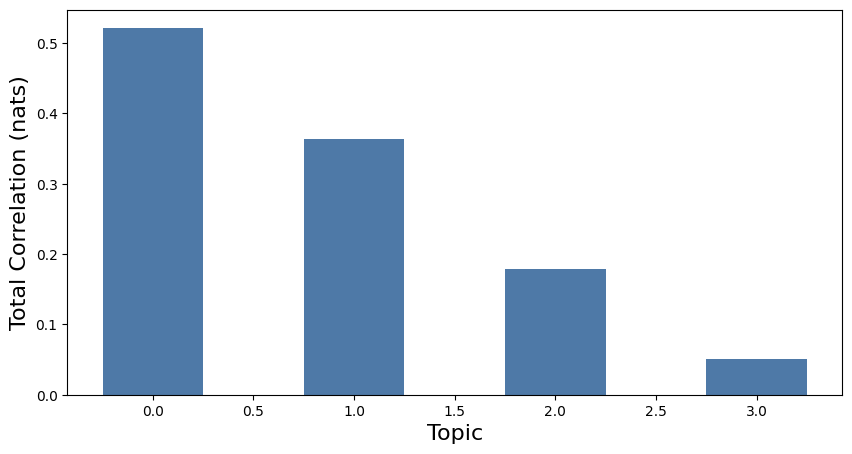

In [23]:
# referenced from https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb
#plotting TC (total correlation) for each topic, used to find ideal hidden toic count
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);